# Finding crop dates using MODIS

In [1]:
# Import logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.captureWarnings(True)

# Import libraries
import json
import calendar
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import *

# Import Descartes Labs' libraries
import descarteslabs as dl
import descarteslabs.workflows as wf

In [2]:
# Load the AOI geojson file
with open('mauritania.geojson') as json_file:
    aoi_json = json.load(json_file)

In [3]:
# Extract dltiles from the large AOI
resolution = 500  # meters
tilesize = 512
dltiles = dl.scenes.DLTile.from_shape(shape=aoi_json['features'][0]['geometry'],
                                        resolution=resolution,
                                        tilesize=tilesize,
                                        pad=0)
tile_keys = [x.key for x in dltiles]
ntiles = len(dltiles)
print('Number of tiles in AOI:', ntiles)

Number of tiles in AOI: 47


### Define "entry_function" which we may use to use Tasks (i.e. parallel compute)

In [101]:
def entry_function(tile_key):
    
    # Import libraries that will be called within the entry_function)
    import logging
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logging.captureWarnings(True)

    import numpy as np
    from datetime import datetime
    
    import descarteslabs as dl
    import descarteslabs.workflows as wf
    
    # Get dltile from tile key
    dltile = dl.scenes.DLTile.from_key(tile_key)
    
    # Define time periods
    year = 2010
    start_date = datetime(year, 1, 1, 0, 0, 0)
    end_date = datetime(year, 12, 31, 23, 59, 59)
    
    # Value used to define crops in the mask
    crop_value = 2
    
    # Get image collection of 16-day rolling composite of MODIS NDVI
    # Workflows make it easy to aggregate the data by date in case
    # there are more than one scene over the tile
    modis_ic = (wf.ImageCollection.from_id("modis:mod13q1:006", 
                                        start_datetime=start_date,
                                        end_datetime=end_date,
                                        resampler='lanczos')
                                 .groupby(dates=("year", "month","day")).sum(axis="images"))
    
    # Extract the NDVI variable
    modis_ndvi = modis_ic.pick_bands('ndvi')
    
    # Get numpy array for NDVI
    modis_data = modis_ndvi.compute(dltile)
    modis_array = modis_data.ndarray
    modis_array = modis_array[:,0]
    
    # Get a list of the dates associated to each scene
    dates_ndvi = modis_ndvi.map(lambda img: img.properties["group"]).compute(dltile)
    
    # Number of time steps in NDVI array
    nt = len(dates_ndvi)
    print('Number of scenes for ' + str(year) + ':', nt)
    
    # Convert dates to datetime objects to easily calculate number of days from January 1st later
    dates_ndvi = list(map(lambda i: datetime(*dates_ndvi[i]), np.arange(0,nt)))
    
    # Load 2015 crop mask using Scenes (can't use Workflows because this
    # product doesn't have an alpha/no data band)
    scenes_mask, ctx = dl.scenes.search(dltile,
                products="usgs:gfsad30:global",
                start_datetime="2014-01-01",
                end_datetime="2016-01-01")
    crop_mask = scenes_mask.mosaic('Land_Cover', ctx, resampler='lanczos')
    crop_mask = crop_mask.astype(float)
    
    # Get the land cover types for the current tile
    land_cover_types = np.unique(crop_mask)
    
    # Continue if there are crops in this tile
    if crop_value in land_cover_types:
        
        # Initialize array where to save the dates of peak NDVI and harvest
        dates_array = np.zeros([2, dltile.tilesize, dltile.tilesize])
        
        # Repeat the crop mask nt times
        crop_mask_tiled = np.repeat(crop_mask, nt, axis=0)
        
        # Mask the NDVI array using the crop mask
        ndvi_masked = np.ma.masked_where(crop_mask_tiled != crop_value, modis_array)
        
        # Find the indices of the maximum value for each pixel
        idx_max = np.argmax(ndvi_masked, axis=0)
        idx_max = np.ma.masked_where(crop_mask[0,:] != crop_value, idx_max)
        
        # Mean value of the index for the peaking date
        mean_idx_max = int(np.nanmean(idx_max))
        print('The mean peak date in this tile is:', dates_ndvi[mean_idx_max])
        
        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.imshow(crop_mask[0,:,:], vmin=0, vmax=crop_value)
        plt.colorbar()
        
        plt.subplot(1,3,2)
        plt.imshow(ndvi_masked[0,:,:], vmin=-1, vmax=1)
        plt.colorbar()
        
        plt.subplot(1,3,3)
        plt.imshow(idx_max, vmin=0, vmax=23, cmap='magma')
        plt.colorbar()
        
        plt.show()
        
        '''
        Up top here we have:
        - Loaded MODIS NDVI array (and corresponding dates)
        - Loaded crop mask (2015)
        - Masked NDVI using crop mask
        - Found the indices of peak NDVI for each pixel
        
        Need to:
        - Implement an algorithm to find the harvest dates for each pixel
        - Fill the array of dimensions (2, 512, 512) with the # days since 
        January 1 for the peak date and the harvest date
        '''
        
    return ndvi_masked


Job ID: 799889e8f52fd694333b2dd58a93ab8ba042eb72d455f24a
[      ] | Steps: 0/0 | Stage: SAVING | Status: SUCCESS                       
Job ID: bd91b48d8a8b724b7dec8e9cfc020f45d01033f49abafe45
[      ] | Steps: 0/0 | Stage: RUNNING | Status: SUCCESS                      Number of scenes for 2010: 23
The mean peak date in this tile is: 2010-08-29 00:00:00


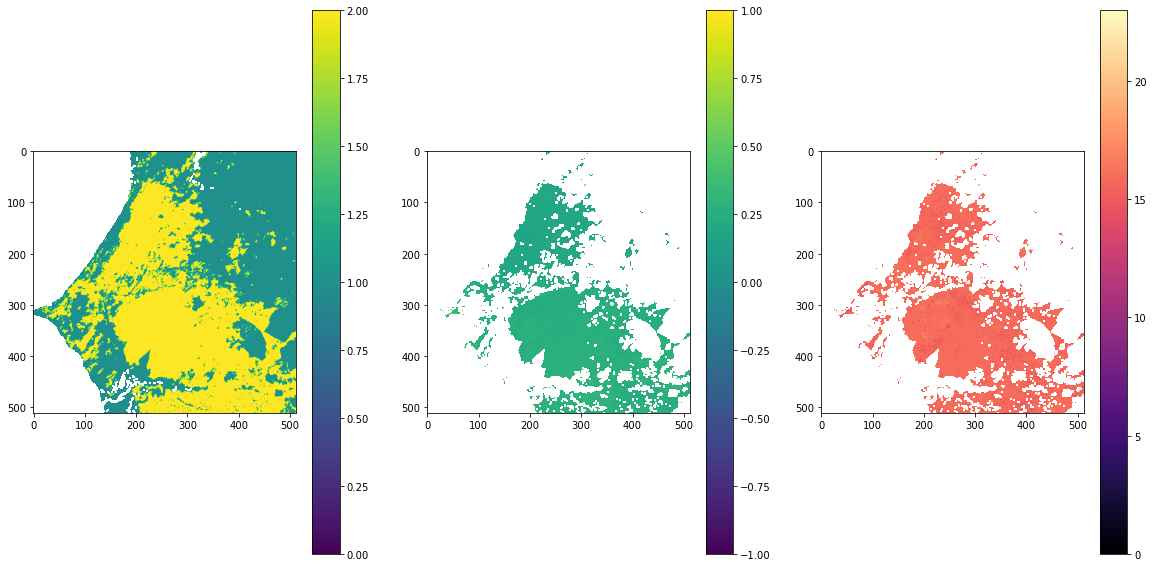

In [102]:
# Test the entry_function for the first tile
ndvi_masked = entry_function(tile_keys[0])